# Clustering ( Kmeans )

In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,tensorflow

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
CPython 3.5.1
IPython 5.1.0

numpy 1.11.2
pandas 0.19.1
tensorflow 0.9.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.1.19-v7+
machine    : armv7l
processor  : armv7l
CPU cores  : 4
interpreter: 32bit


In [3]:
import pandas as pd
import tensorflow as tf
import seaborn as sns

1000개의 데이터를 난수로 생성합니다. 
 - 대략 절반 정도는 평균:0.5, 표준편차:0.6의 x값과 평균:0.3, 표준편차:0.9의 y값을 가진다.
 - 나머지 절만 정도는 평균:2.5, 표준편차:0.4의 x값과 평균:0.8, 표준편차:0.5의 y값을 가집니다.

In [4]:
num_vectors = 1000
num_clusters = 3
num_steps = 100
vector_values = []
for i in range(num_vectors):
  if np.random.random() > 0.5:
    vector_values.append([np.random.normal(0.5, 0.6),
                          np.random.normal(0.3, 0.9)])
  else:
    vector_values.append([np.random.normal(2.5, 0.4),
                         np.random.normal(0.8, 0.5)])

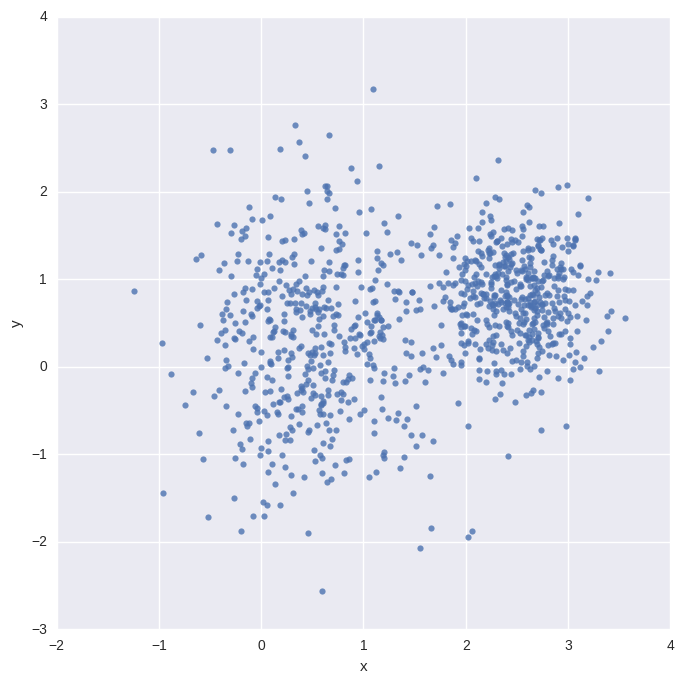

In [5]:
df = pd.DataFrame({"x": [v[0] for v in vector_values], 
                   "y": [v[1] for v in vector_values]})
sns.lmplot("x", "y", data=df, fit_reg=False, size=7)

vector_values를 사용하여 constant를 만들고 초기 센트로이드 세개를 랜덤하게 선택합니다. 그런 후에 vectors, centroids 텐서에 각각 차원을 추가합니다.

 - Slice
        input' is [[[1, 1, 1], [2, 2, 2]],
                   [[3, 3, 3], [4, 4, 4]],
                    [[5, 5, 5], [6, 6, 6]]]

        tf.slice(input, [1, 0, 0], [1, 1, 3]) ==> [[[3, 3, 3]]]
        tf.slice(input, [1, 0, 0], [1, 2, 3]) ==> [[[3, 3, 3],
                                                    [4, 4, 4]]]
        tf.slice(input, [1, 0, 0], [2, 1, 3]) ==> [[[3, 3, 3]],
                                                   [[5, 5, 5]]]
 - Shuffle 
         [[1, 2],       [[5, 6],
         [3, 4],  ==>   [1, 2],
         [5, 6]]        [3, 4]]

In [21]:
vectors = tf.constant(vector_values) # 만든 데이터를 상수로 Tensor로 옮긴다.
# 알고리즘은 처음 시작할 때 초기 중심을 지정해야 한다. 아래 코드는 초기 단계에 해당.
# 앞에서 말한 것 처럼 무작위로 K개의 데이터를 선택하는 방법을 사용.
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [num_clusters,-1])) # [0,0] 데이터를 [3,-1] 사이즈로 Slice 
print(vectors.get_shape()) # 1000개의 데이터가 X, Y 좌표로 2차원으로 나타내진다. 
print(centroids.get_shape()) # 3개의 클러스터를 선택 (x,y좌표와 함께) => (3,2)

# 차원을 추가하는 이유는 차원을 맞추어 유클리드 거리를 구할 수 있도록 ( Sub )
expanded_vectors = tf.expand_dims(vectors, 0) # D0 차원을 추가 => (추가된 차원, X, Y) 
expanded_centroids = tf.expand_dims(centroids, 1) # D1 차원을 추가 => (X,추가된 차원, Y)

print(expanded_vectors.get_shape())
print(expanded_centroids.get_shape())

(1000, 2)
(3, 2)
(1, 1000, 2)
(3, 1, 2)


각 데이터 포인트에서 가장 가까운 센트로이드의 인덱스를 계산합니다.
 - 유클리드 거리 활용. 

In [14]:
distances = tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)

각 클러스터의 평균 값을 계산하여 새로운 센트로이드를 구합니다.

- Concat
        t1 = [[1, 2, 3], [4, 5, 6]]
        t2 = [[7, 8, 9], [10, 11, 12]]
        tf.concat(0, [t1, t2]) ==> [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
        tf.concat(1, [t1, t2]) ==> [[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]]

In [22]:
means = tf.concat(0, [
  tf.reduce_mean(
      tf.gather(vectors,  # indices must be an integer tensor of any dimension (usually 0-D or 1-D). Produces an output tensor with shape 
                tf.reshape( # tf.reshape(tensor, shape, name=None) 
                    # Given tensor, this operation returns a tensor that has the same values as tensor with shape shape.
                  tf.where( # Return the elements, either from x or y, depending on the condition.
                    tf.equal(assignments, c) # Returns the truth value of (x == y) element-wise.
                  ),[1,-1]) # reshape [1, maximun of vectors]
               ),reduction_indices=[1])  # x, y의 중심을 구하는 [Center of X, Center of Y ]
  for c in range(num_clusters)])

update_centroids = tf.assign(centroids, means) # Update 'ref' by assigning 'value' to it.

In [23]:
init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)

In [24]:
for step in range(num_steps):
   _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])

print("centroids")
print(centroid_values)

centroids
[[ 2.53336525  0.18040524]
 [ 1.39986849  0.83668935]
 [ 0.46494821 -0.99245298]]


vector_values 데이터를 클러스터에 따라 색깔을 구분하여 산포도를 그립니다.

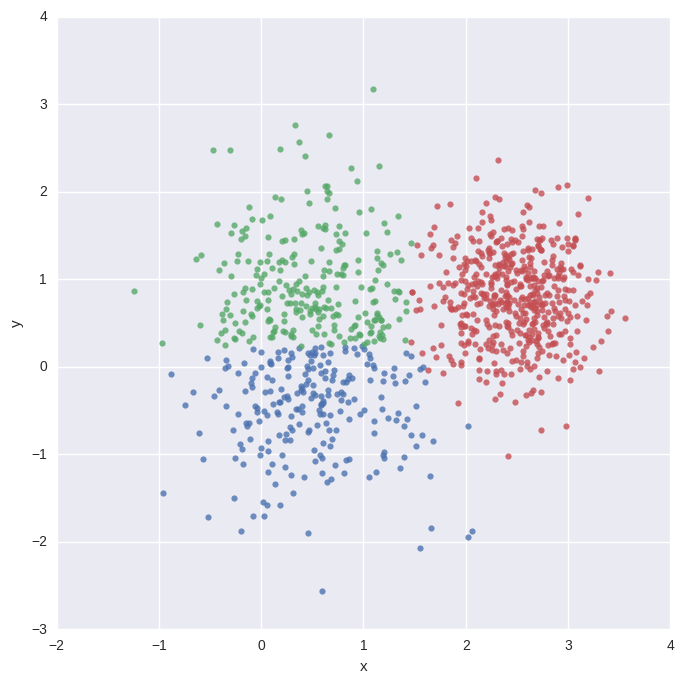

In [18]:
data = {"x": [], "y": [], "cluster": []}
for i in range(len(assignment_values)):
    data["x"].append(vector_values[i][0])
    data["y"].append(vector_values[i][1])
    data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, size=7, 
           hue="cluster", legend=False)
plt.show()